# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [ ]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
from worclipo.load_data import load_data
#from worcliver.load_data import load_data
#from ecg.load_data import load_data

# Import classifiers
from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

X = data.drop("label",axis=1)
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    print(f"Fold {fold}:")
    print(f" - Train size: {len(X_train_fold)}")
    print(f" - Validation size: {len(X_val_fold)}")


The number of samples: 115
The number of columns: 494


General functions to be used

In [2]:
# Some functions we will use
def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

def load_breast_cancer(n_features=2):
    '''
    Load the sklearn breast data set, but reduce the number of features with PCA.
    '''
    data = ds.load_breast_cancer()
    x = data['data']
    y = data['target']

    p = PCA(n_components=n_features)
    p = p.fit(x)
    x = p.transform(x)
    return x, y

def load_boston(n_features=1):
    '''
    Load the sklearn boston data set, but reduce the number of features with PCA.
    '''
    data = ds.load_boston()
    x = data['data']
    y = data['target']

    p = PCA(n_components=n_features)
    p = p.fit(x)
    x = p.transform(x)
    return x, y

def load_diabetes(n_features=1):
    '''
    Load the sklearn bdiabetes data set, but reduce the number of features with PCA.
    '''
    data = ds.load_diabetes()
    x = data['data']
    y = data['target']

    p = PCA(n_components=n_features)
    p = p.fit(x)
    x = p.transform(x)
    return x, y

### Preprocessing

Missing data
* Part 1: Finding missing data

In [3]:
# Define missing value indicators
custom_missing = ['NA', 'N/A', '?', 'None', 'none', '-']

# Count NaNs
nan_counts = X_train.isna().sum()

# Count empty strings
empty_string_counts = (X_train == '').sum()

# Count custom missing indicators (case-insensitive match)
custom_missing_counts = X_train.apply(lambda col: col.astype(str).str.lower().isin([val.lower() for val in custom_missing]).sum())

# Compute total missing count per column
total_missing = nan_counts + empty_string_counts + custom_missing_counts

# Filter out columns where total missing is zero
total_missing_selected = total_missing[total_missing != 0]

# Print total missing counts
print(total_missing_selected)

Series([], dtype: int64)


* Part 2: Processing missing data

In [4]:
# Import
import numpy as np
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro

# Replacing missing values with NaN
custom_missing = ['NA', 'N/A', '?', 'None', 'none', '-', '']
X_train.replace(custom_missing, np.nan, inplace=True)
X_test.replace(custom_missing, np.nan, inplace=True)

# If 50% or more of the data within one feature is missing the feature is deleted
limit = len(X_train.index)*50/100
valid_columns = [col for col, count in total_missing.items() if count < limit]

# Keep only the valid columns in both X_train and X_test
X_train = X_train[valid_columns]
X_test = X_test[valid_columns]

# Imputate 

# Check if imputation is needed
if X_train.isna().sum().sum() == 0:
    pass
else:
    # Dictionary to store mean/median decision per column
    imputation_strategies = {}

    for col in X_train.select_dtypes(include=['number']).columns:  # Only numeric columns
        col_data = X_train[col].dropna()  # Remove NaN values for testing

        if len(col_data) > 3:  # Shapiro requires at least 3 non-null values
            if col_data.nunique() == 1:  # Check if all values are the same
                strategy = 'median'  # Default to median if no variability
            else:
                _, p = shapiro(col_data)
                strategy = 'mean' if p > 0.05 else 'median'
        else:
            strategy = 'median'  # Default to median if too few values

        imputation_strategies[col] = strategy

    # Create imputers for mean and median
    mean_imputer = SimpleImputer(strategy='mean')
    median_imputer = SimpleImputer(strategy='median')

    # Apply imputers for each feature
    for col, strategy in imputation_strategies.items():
        imputer = mean_imputer if strategy == 'mean' else median_imputer
        X_train[col] = imputer.fit_transform(X_train[[col]])
        X_test[col] = imputer.transform(X_test[[col]])  # Use the same imputer

Scaling data

In [ ]:
import pandas as pd
from sklearn import preprocessing

scaler_robust = preprocessing.RobustScaler()

scaled_robust_array_train = scaler_robust.fit_transform(X_train)
scaled_robust_array_test = scaler_robust.transform(X_test)

X_scaled_robust_train = pd.DataFrame(scaled_robust_array_train, columns=X_train.columns)
X_scaled_robust_test = pd.DataFrame(scaled_robust_array_test, columns=X_test.columns)

# print(X_scaled_robust_train)

    PREDICT_original_sf_compactness_avg_2.5D  \
0                                   0.311125   
1                                  -0.711701   
2                                   0.909548   
3                                  -0.094719   
4                                   0.841177   
..                                       ...   
81                                 -0.882556   
82                                 -0.900222   
83                                 -0.081870   
84                                  1.175088   
85                                  0.240824   

    PREDICT_original_sf_compactness_std_2.5D  \
0                                  -0.017272   
1                                   0.162159   
2                                  -0.333623   
3                                   0.117707   
4                                  -0.563987   
..                                       ...   
81                                  0.330932   
82                                  0.5

### Feature extraction

Lloyd

Greedy feature selection, forward

In [ ]:
%pip install mlxtend

# Greedy feature selection (forward)

# importing the models
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# calling the classifier for the feature selction
clf = LogisticRegression(max_iter=500, random_state=42)
svc = svm.SVC(kernel="linear")

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Greedy forward selection and fitting (select 10 best features)
sfs1 = SequentialFeatureSelector(clf, n_features_to_select=10, direction='forward', scoring='accuracy', cv=cv)
sfs1.fit(X_train, y_train)

# print selected feature names
selected_features = X_train.columns[sfs1.get_support()]
print("Selected features:", selected_features)

Rfecv en svm

In [ ]:
# Recursive Feature Elimination with Cross-Validation (RFECV)

# Import libraries
from sklearn import feature_selection
from sklearn import svm
import matplotlib.pyplot as plt

# calling the classifier (SVM model) for the feature selection
svc = svm.SVC(kernel="linear")

# RFECV feature selection and fitting
rfecv = feature_selection.RFECV(
    estimator=svc, step=5,
    cv=model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

rfecv.fit(X_train, y_train)

# print selected feature names
selected_features = X_train.columns[sfs1.get_support()]
print("Selected features:", selected_features)

# plot the number of features vs. accuracy
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()

Univariate testing (ANOVA) 

(493, 3)
                                               Feature  F-Statistic   p-value
20                     PREDICT_original_sf_volume_2.5D    21.368221  0.000014
326          PREDICT_original_tf_Gabor_mean_F0.2_A0.79    18.433658  0.000047
313           PREDICT_original_tf_Gabor_mean_F0.2_A0.0    16.632613  0.000103
17                   PREDICT_original_sf_area_max_2.5D    15.571112  0.000164
19                   PREDICT_original_sf_area_std_2.5D    14.946289  0.000217
16                   PREDICT_original_sf_area_avg_2.5D    13.076369  0.000509
404          PREDICT_original_tf_Gabor_mean_F0.5_A2.36    12.860625  0.000562
378          PREDICT_original_tf_Gabor_mean_F0.5_A0.79    12.781226  0.000584
114            PREDICT_original_tf_LBP_entropy_R15_P36    11.386565  0.001121
466   PREDICT_original_phasef_monogenic_entropy_WL3_N5    11.351598  0.001140
365           PREDICT_original_tf_Gabor_mean_F0.5_A0.0    11.109501  0.001279
101             PREDICT_original_tf_LBP_entropy_R8_P24 

c:\Users\lloyd\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 76  77  85  90  96  97 103 422 423 435 436 448 449 467 474 475 480 487
 488] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\lloyd\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


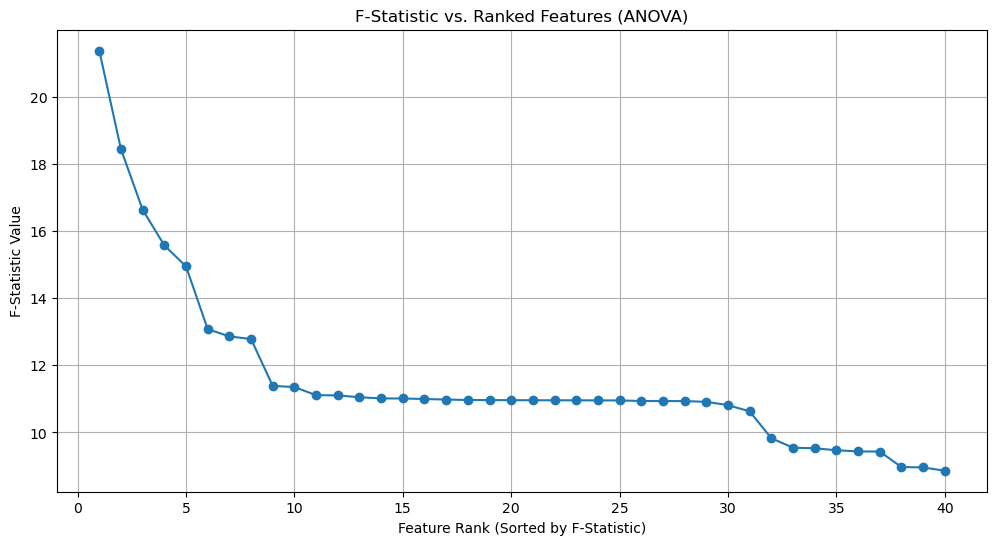

Selected features using ANOVA: Index(['PREDICT_original_sf_area_avg_2.5D',
       'PREDICT_original_sf_area_max_2.5D',
       'PREDICT_original_sf_area_std_2.5D', 'PREDICT_original_sf_volume_2.5D',
       'PREDICT_original_hf_entropy', 'PREDICT_original_logf_entropy_sigma1',
       'PREDICT_original_logf_entropy_sigma5',
       'PREDICT_original_logf_entropy_sigma10',
       'PREDICT_original_tf_LBP_entropy_R3_P12',
       'PREDICT_original_tf_LBP_entropy_R8_P24',
       'PREDICT_original_tf_LBP_mean_R15_P36',
       'PREDICT_original_tf_LBP_skewness_R15_P36',
       'PREDICT_original_tf_LBP_entropy_R15_P36',
       'PREDICT_original_tf_Gabor_entropy_F0.05_A0.0',
       'PREDICT_original_tf_Gabor_mean_F0.05_A0.79',
       'PREDICT_original_tf_Gabor_entropy_F0.05_A0.79',
       'PREDICT_original_tf_Gabor_entropy_F0.05_A1.57',
       'PREDICT_original_tf_Gabor_entropy_F0.05_A2.36',
       'PREDICT_original_tf_Gabor_mean_F0.2_A0.0',
       'PREDICT_original_tf_Gabor_energy_F0.2_A0.0',
   

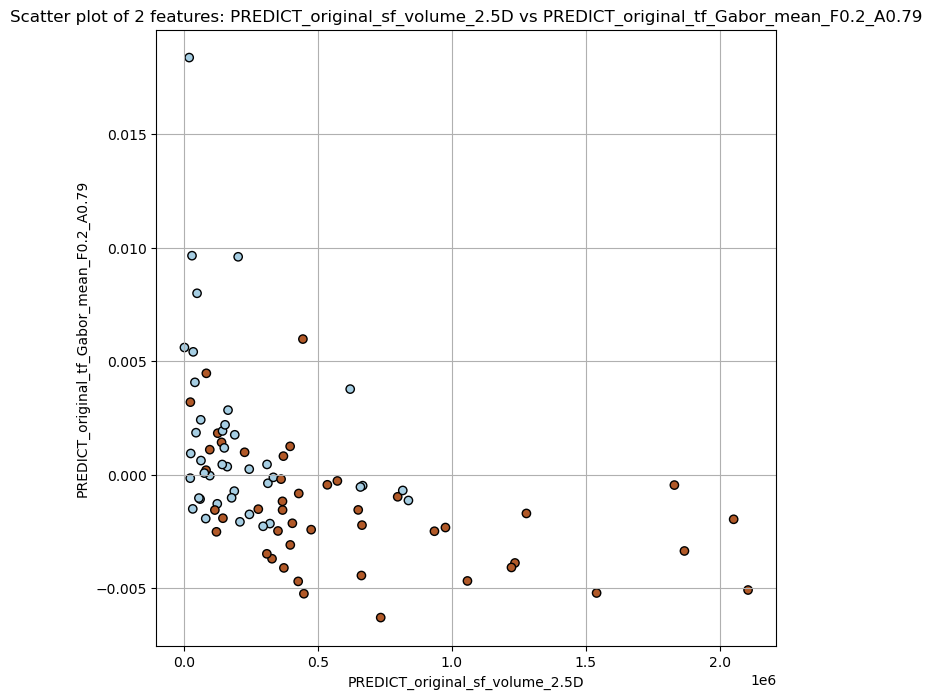

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Zet de labels om naar numerieke waarden
le = LabelEncoder()
y_train_numeric = le.fit_transform(y_train)
legend_labels = le.classes_  # Toont de mapping van labels naar nummers

# ANOVA F-test (lineaire relaties)
selector_anova = SelectKBest(f_classif, k=40)
X_filtered_anova = selector_anova.fit_transform(X_scaled_robust_train, y_train)
anova_features = X_scaled_robust_train.columns[selector_anova.get_support()]
# print(anova_features)
f_values, p_values = selector_anova.scores_, selector_anova.pvalues_

# Create a DataFrame to display features with their corresponding F-statistics and p-values
anova_results = pd.DataFrame({'Feature': X_scaled_robust_train.columns,'F-Statistic': f_values, 'p-value': p_values})

# Sort by F-statistic (highest to lowest) to find the most statistically significant features
anova_results_sorted_by_F = anova_results.sort_values(by='F-Statistic', ascending=False)
anova_results_sorted_by_F = anova_results_sorted_by_F[anova_results_sorted_by_F['Feature'].isin(anova_features)]
print(anova_results_sorted_by_F)

# Plot de F-statistic per feature
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(anova_results_sorted_by_F) + 1), anova_results_sorted_by_F['F-Statistic'], marker='o')
plt.xlabel("Feature Rank (Sorted by F-Statistic)")
plt.ylabel("F-Statistic Value")
plt.title("F-Statistic vs. Ranked Features (ANOVA)")
plt.grid(True)
plt.show()

# Mutual Information (niet-lineaire relaties)
selector_mi = SelectKBest(mutual_info_classif, k=100)
X_filtered_mi = selector_mi.fit_transform(X_scaled_robust_train, y_train)
mi_features = X_scaled_robust_train.columns[selector_mi.get_support()]

# Gemeenschappelijke features
common_features = list(set(anova_features).intersection(set(mi_features)))

# Unieke features voor ANOVA en MI
unique_anova = list(set(anova_features) - set(mi_features))
unique_mi = list(set(mi_features) - set(anova_features))

# Print de resultaten
print("Selected features using ANOVA:", anova_features)
print("Selected features using Mutual Information:", mi_features)
print("Common features (selected by both ANOVA and MI):", common_features)
print("Unique features to ANOVA:", unique_anova)
print("Unique features to MI:", unique_mi)
print(len(common_features))

# fig = plt.figure(figsize=(24,8))
# ax = fig.add_subplot(131)
# ax.set_title("First two features of ANOVA test", fontsize='small')
# scatter = ax.scatter(X_filtered_anova[:, 0], X_filtered_anova[:, 2], marker='o', c=y_train_numeric,
#             s=25, edgecolor='k', cmap=plt.cm.Paired)

# # Haal de juiste legenda-elementen op
# handles, _ = scatter.legend_elements()
# legend1 = ax.legend(handles, legend_labels, title="classes")
# ax.add_artist(legend1)
# plt.show()

example_features = anova_results_sorted_by_F.iloc[0:2]['Feature'].values
fig = plt.figure(figsize=(8,8))
plt.scatter(X_train[example_features[0]], X_train[example_features[1]], c=y_train_numeric, cmap=plt.cm.Paired, edgecolor='k')
plt.xlabel(example_features[0])
plt.ylabel(example_features[1])
plt.title(f"Scatter plot of 2 features: {example_features[0]} vs {example_features[1]}")
plt.grid(True)

plt.show()

Apply RFECV/SFS after ANOVA selecting

In [ ]:
# Further Feature Selection with RFE

# import modules
from sklearn import feature_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import svm

# calling the classifier (SVM model or linear regression) for the feature selection
svc = svm.SVC(kernel="linear")
# clf = LogisticRegression(max_iter=500, random_state=42)

cv = model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# RFECV feature selection and fitting
rfecv_anova = feature_selection.RFECV(estimator=svc,
                                      step=5,
                                      cv=cv,
                                      scoring='roc_auc')

rfecv_mi = feature_selection.RFECV(estimator=svc,
                                   step=5,
                                   cv=cv,
                                   scoring='roc_auc')

rfecv_anova.fit(X_filtered_anova, y_train)
rfecv_mi.fit(X_filtered_mi, y_train)

In [ ]:
# print selected feature names and the number of features selected
selected_features_anova = anova_features[rfecv_anova.support_]
selected_features_mi = mi_features[rfecv_mi.support_]

print("Features selected with ANOVA and RFECV:", list(selected_features_anova))
print("Features selected with MI and RFECV::", list(selected_features_mi))

print("Number of features selected with ANOVA and RFECV:", sum(rfecv_anova.support_))
print("Number of features  selected with MI and RFECV:", sum(rfecv_mi.support_))

# plot the number of features vs. accuracy
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_anova.cv_results_["mean_test_score"]) + 1), rfecv_anova.cv_results_["mean_test_score"], label="ANOVA + RFECV", color="blue")
plt.plot(range(1, len(rfecv_mi.cv_results_["mean_test_score"]) + 1), rfecv_mi.cv_results_["mean_test_score"], label="MI + RFECV", color="red")
plt.legend()
plt.show()

Simple classifiers

In [ ]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# Zet de labels om naar numerieke waarden
le = LabelEncoder()
y_train = le.fit_transform(y_train)  # Zet 'lipoma' en 'liposarcoma' om naar 0 en 1
y_test = le.transform(y_test)  # Pas dezelfde transformatie toe op y_test

# Define the classifiers
classifiers = [
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(),
    LogisticRegression(max_iter=5000),
    SGDClassifier(max_iter=5000, tol=1e-3),
    KNeighborsClassifier(n_neighbors=40),
    DecisionTreeClassifier(random_state=42)
]

# Store fitted classifiers
clfs_fit = []

# Select the same features for the test set
X_train_selected = X_filtered_anova  # Train-set met ANOVA-geselecteerde features
X_test_selected = selector_anova.transform(X_test)  # Test-set met ANOVA-features

# Train and evaluate classifiers
for clf in classifiers:
    # Train classifier
    clf.fit(X_scaled_robust_train, y_train)
    Y_pred = clf.predict(X_scaled_robust_test)

    # Store fitted classifier
    clfs_fit.append(clf)

    # Compute evaluation metrics
    accuracy = metrics.accuracy_score(y_test, Y_pred)

    if hasattr(clf, 'predict_proba'):
        y_score = clf.predict_proba(X_scaled_robust_test)[:, 1]  # Probability for class 1
    else:
        y_score = Y_pred  # Use binary predictions if probability is unavailable

    auc = metrics.roc_auc_score(y_test, y_score)
    f1 = metrics.f1_score(y_test, Y_pred)
    precision = metrics.precision_score(y_test, Y_pred)
    recall = metrics.recall_score(y_test, Y_pred)

    # Print the results
    print(f"Classifier: {clf.__class__.__name__}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  AUC: {auc:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print("-" * 50)

Inge: Optimization based feature selection > Lasso 

Label Mapping: {0: 'lipoma', 1: 'liposarcoma'}
Best alpha found: 0.08119844993184008
Selected Features: Index(['PREDICT_original_sf_compactness_std_2.5D',
       'PREDICT_original_sf_volume_2.5D',
       'PREDICT_original_tf_GLCMMS_contrastd3.0A2.36mean',
       'PREDICT_original_tf_GLCMMS_contrastd3.0A2.36std',
       'PREDICT_original_tf_Gabor_skewness_F0.05_A0.0',
       'PREDICT_original_tf_Gabor_min_F0.05_A1.57',
       'PREDICT_original_tf_Gabor_mean_F0.2_A0.0',
       'PREDICT_original_tf_Gabor_mean_F0.2_A0.79',
       'PREDICT_original_tf_Gabor_peak_F0.2_A0.79',
       'PREDICT_original_tf_Gabor_peak_F0.2_A1.57'],
      dtype='object')
Lasso like E2.3
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regulari

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.240e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.212e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.212e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.227e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.208e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.266e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.266e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.267e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.482e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.482e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.457e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.994e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.015e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.090e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.119e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.163e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.165e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.178e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.429e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.405e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.511e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.781e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.960e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.585e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.491e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.455e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.002e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.180e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.865e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.061e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.764e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.535e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.227e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.495e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.347e+00, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.724e-01, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.612e-01, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.488e-02, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.843e-02, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.286e-02, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.276e-03, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.440e-03, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e-02, tolerance: 4.300e-03
  model = cd_fast.enet_coordinate_descent(
/Users/ingeheddes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86
	 Misclassified: 86 / 86


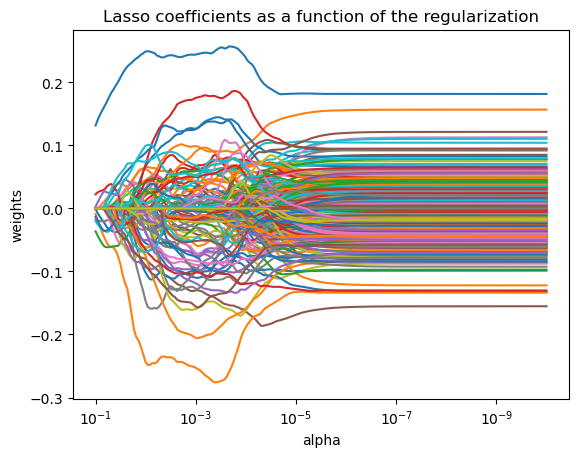

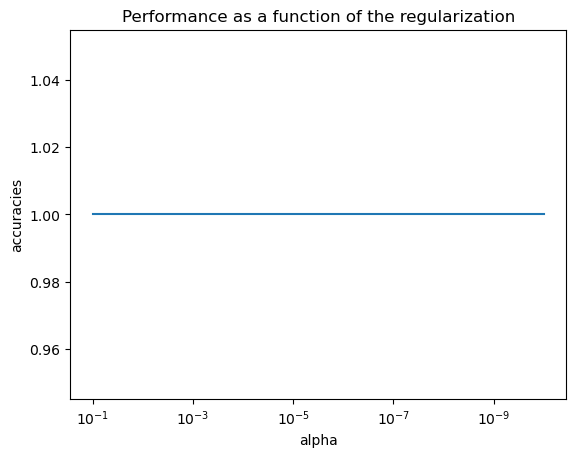

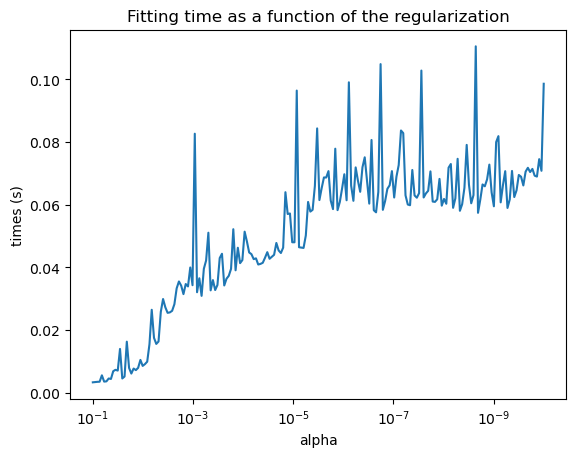

Feature extraction: PCA


In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

# Encode y labels to numeric values
le = LabelEncoder()
y_train_numeric = le.fit_transform(y_train)
y_test_numeric = le.transform(y_test)

# Store the mapping of labels
legend_labels = le.classes_  # This saves the original class names
print("Label Mapping:", {i: label for i, label in enumerate(legend_labels)})

# Define LassoCV with cross-validation
n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)# Testing alpha from 0.0001 to 10
random_state = 42 #  Using int will produce the same results everytime, 42 is along 0 the most popular choice
lasso_cv = LassoCV(cv=5, alphas=alphas, random_state=random_state, max_iter=10000)  # TODO: cv = 5 chosen, what do we want?

# Fit LassoCV on training data
lasso_cv.fit(X_scaled_standard_train, y_train_numeric)

# Get the best alpha value
best_alpha = lasso_cv.alpha_
print(f"Best alpha found: {best_alpha}")

# Train final Lasso model with optimal alpha
lasso = Lasso(alpha=best_alpha, fit_intercept=False)
lasso.fit(X_scaled_standard_train, y_train_numeric)

# Select features
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_scaled_standard_train)
X_test_selected = selector.transform(X_scaled_standard_test)

# Get selected feature indices and names
selected_features = np.where(selector.get_support())[0]
selected_feature_names = X_scaled_standard_train.columns[selected_features]
print("Selected Features:", selected_feature_names)

# #############################################################################
# #############################################################################

print('Lasso like E2.3 which is a classifier')
from time import time

# Construct classifiers
coefs = []
accuracies = []
times = []
for a in alphas:
    # Fit classifier
    clf = Lasso(alpha=a, fit_intercept=False)
    t0 = time()
    clf.fit(X_scaled_standard_train, y_train_numeric)
    duration = time() - t0
    y_pred = clf.predict(X_scaled_standard_train)
    message = ("\t Misclassified: %d / %d" % ((y_train_numeric != y_pred).sum(), y_train_numeric.shape[0])) # TODO: GEEN TEST!!

    print(message)

    # Append statistics
    accuracy = float((y_train_numeric != y_pred).sum()) / float(y_train_numeric.shape[0])
    times.append(duration)
    accuracies.append(accuracy)
    coefs.append(clf.coef_)

# #############################################################################
# Display results

# Weights
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Performance
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('accuracies')
plt.title('Performance as a function of the regularization')
plt.axis('tight')
plt.show()

# Times
plt.figure()
ax = plt.gca()
ax.plot(alphas, times)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('times (s)')
plt.title('Fitting time as a function of the regularization')
plt.axis('tight')
plt.show()

# #############################################################################
# #############################################################################

print('Feature extraction: PCA')
# Apply PCA (only fit on training data)
from sklearn.decomposition import PCA

n_features = 4  # TODO: determine what n_features should become
pca = PCA(n_components=n_features)
X_scaled_standard_train_PCA = pca.fit_transform(X_scaled_standard_train)
X_scaled_standard_test_PCA = pca.transform(X_scaled_standard_test)  # Use the same transformation

## Model selection
Random forest, decision tree and bagging

In [9]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Encode categorical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Define models and parameter distributions
models = {
    "Random Forest": (RandomForestClassifier(), {
        'n_estimators': randint(5, 200),
        'max_depth': randint(3, 30),
        'min_samples_split': randint(2, 20),
        'bootstrap': [True, False]
    }),
    "Bagging": (BaggingClassifier(DecisionTreeClassifier()), {
        'n_estimators': randint(5, 200),
        'estimator__max_depth': randint(3, 30),
        'estimator__min_samples_split': randint(2, 20),
        'bootstrap': [True, False]
    }),
    "Decision Tree": (DecisionTreeClassifier(), {
        'max_depth': randint(3, 30),
        'min_samples_split': randint(2, 20)
    })
}

# Perform Randomized Search and store results
best_estimators = {}
best_params = {}
best_scores = {}

for name, (model, param_dist) in models.items():
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=20,
        scoring='accuracy',
        cv=10,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train_encoded)
    
    best_estimators[name] = search.best_estimator_
    best_params[name] = search.best_params_
    best_scores[name] = search.best_score_

# Print results
print("\n=== Model Comparison ===")
for name in models.keys():
    print(f"\nBest {name}: {best_estimators[name]}")
    print(f"Best {name} Parameters: {best_params[name]}")
    print(f"Best {name} Accuracy: {best_scores[name]:.4f}")



=== Model Comparison ===

Best Random Forest: RandomForestClassifier(bootstrap=False, max_depth=17, min_samples_split=13,
                       n_estimators=59)
Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 17, 'min_samples_split': 13, 'n_estimators': 59}
Best Random Forest Accuracy: 0.7125

Best Bagging: BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6,
                                                   min_samples_split=9),
                  n_estimators=156)
Best Bagging Parameters: {'bootstrap': True, 'estimator__max_depth': 6, 'estimator__min_samples_split': 9, 'n_estimators': 156}
Best Bagging Accuracy: 0.7694

Best Decision Tree: DecisionTreeClassifier(max_depth=24, min_samples_split=3)
Best Decision Tree Parameters: {'max_depth': 24, 'min_samples_split': 3}
Best Decision Tree Accuracy: 0.7167
